In [1]:
%matplotlib inline

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(100)

# Comparing Monte Carlo and Temporal Difference Learning
## The Game
We have five non-terminal states. In each state, we have two deterministic actions, left and right. We want to estimate the value function of the uniform random policy. 
- All episodes start in state C;
- Episodes terminate either on the left or on the right;
- The reward is 0 on all transitions except +1 for terminating on the right.

Note that in this problem, the value has an intuitive meaning. The value of each state is the probability terminating on the right when starting from each state. Under the uniform random policy, the value of the start state is 0.5, that means the probability of terminating with +1 from the center is a half. If we start further to left, the probability of terminating with +1 decreases: and vice versa for the right.

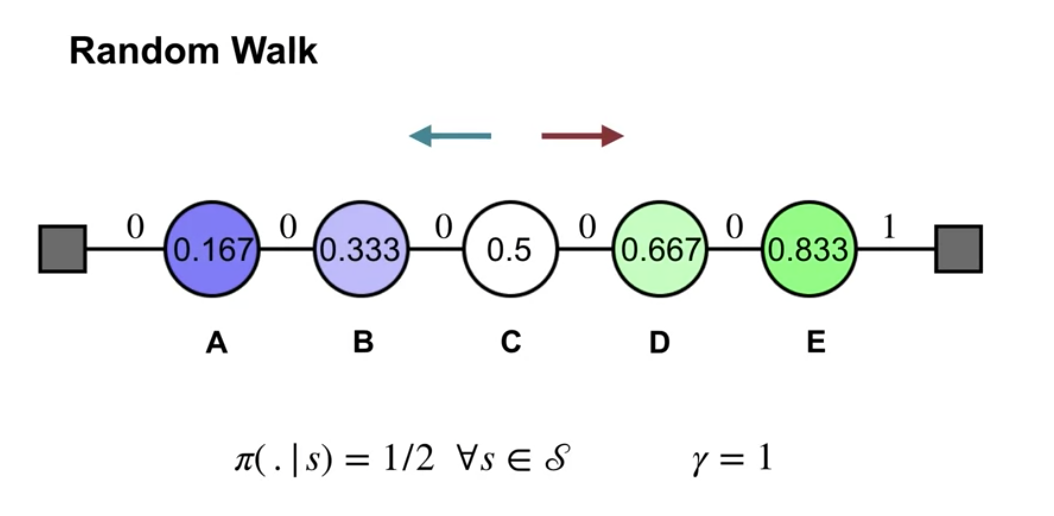

In [2]:
Image("the game.png")

In [3]:
def run_episode():
    
    actions = [-1, 1]  # Left, right
    action_sequence = np.array([])
    
    while True:
        
        # Draw 30 random actions
        seq = np.random.choice(actions, size=30, replace=True)
        action_sequence = np.concatenate([action_sequence, seq], axis=0)
        cumsum = action_sequence.cumsum()
        
        # Cumsum == 3 means right-hand terminal reached
        right_terminal = np.where(cumsum == 3, True, 0)
        end_right_arr = np.argwhere(right_terminal)
        
        # Cumsum == -3 means left-hand terminal reached
        left_terminal = np.where(cumsum == -3, True, 0)
        end_left_arr = np.argwhere(left_terminal)
        
        # Check whether either terminal state has been reached 
        reached_right = end_right_arr.size > 0
        reached_left = end_left_arr.size > 0
        
        if reached_right or reached_left:
            break
        else:
            continue
    
    # Which terminal state?
    if reached_right and reached_left:
        end_right = end_right_arr[0, 0] < end_left_arr[0, 0]

    elif reached_right:
        end_right = True
        
    else:
        end_right = False

    # Allocate reward
    if end_right:
        end_idx = end_right_arr[0, 0] + 1
        sequence = action_sequence[:end_idx]
        reward = np.zeros_like(sequence)
        reward[-1] = 1
        
    else:
        end_idx = end_left_arr[0, 0] + 1
        sequence = action_sequence[:end_idx]
        reward = np.zeros_like(sequence)
        
    states = np.array([3.])  # Start state
    states = np.concatenate([states, sequence.cumsum() + 3], axis=0)
    states = states[:-1]
    
    return states, sequence, reward

In [4]:
class Agent:

    def __init__(self, gamma=1):
        state_values = np.zeros(7)  # Initialisation
        state_values[1:-1] = 0.5
        self.state_values = state_values
        self.N = np.zeros(7)
        self.gamma = gamma
    
    def rmse(self, true_values):
        state_values = np.array(self.state_values[1:-1])
        sq_error = (true_values - state_values) ** 2
        return np.mean(np.sqrt(sq_error))


class MonteCarlo(Agent):

    def __init__(self, gamma=1, first_visit=True):
        super().__init__(gamma)
        self.first_visit = first_visit

    def update_state_values(self, episode):

        states, actions, rewards = episode
        returns = self.get_returns(episode)
        iterable = tuple(zip(states, returns))

        # only relevant if first_visit=True
        unique = np.unique(states).tolist()
        seen = []

        for i in iterable:
            state, est_return = i

            try:
                assert state not in seen

            except AssertionError:
                continue

            else:
                if self.first_visit:
                    seen.append(state)

            finally:
                idx = int(state)

                self.N[idx] += 1
                step_size = 1 / self.N[idx]

                error = est_return - self.state_values[idx]
                self.state_values[idx] += step_size * error

                if self.first_visit and unique == sorted(seen):
                    break

    def get_returns(self, episode):
        returns = []
        s, a, r = episode

        for step in range(len(s)):
            idx = step + 1
            gammas = np.array([self.gamma] * idx)
            powers = np.array([x for x in range(idx)])
            discounted_gammas = gammas ** powers
            rewards = np.array(r[-idx:])
            returns.append(np.sum(discounted_gammas * rewards))

        return returns


class TemporalDifference(Agent):

    def __init__(self, gamma=1, alpha=1):
        super().__init__(gamma)
        self.alpha = alpha

    def update_state_values(self, episode):

        n_steps = len(episode[1])

        for step in range(n_steps):
            s, a, r = tuple(map(lambda x: x[step], episode))
            idx = int(s)
            next_s_idx = int(idx + a)
            next_s_value = self.state_values[next_s_idx]

            td_error = r + self.gamma * next_s_value - self.state_values[idx]
            self.state_values[idx] += self.alpha * td_error


In [5]:
def run_100_iterations(true_vals, keep_checkpoints=True, checkpoints=None):
    iterations = 100
    
    first_values = []
    every_values = []
    one_values = []
    half_values = []

    rmse_first_mc = [] 
    rmse_every_mc = []
    rmse_td_one = []
    rmse_td_half = []

    true_values = np.array(true_vals)

    mc_first = MonteCarlo()
    mc_every = MonteCarlo(first_visit=False)
    td_one = TemporalDifference()
    td_half = TemporalDifference(alpha=0.5)

    for i in range(iterations):
        episode = run_episode()

        mc_first.update_state_values(episode)
        rmse_first_mc.append(mc_first.rmse(true_values))

        mc_every.update_state_values(episode)
        rmse_every_mc.append(mc_every.rmse(true_values))

        td_one.update_state_values(episode)
        rmse_td_one.append(td_one.rmse(true_values))

        td_half.update_state_values(episode)
        rmse_td_half.append(td_half.rmse(true_values))

        if keep_checkpoints and i in checkpoints :
            first_values.append(mc_first.state_values.round(2).tolist()[1:-1])
            every_values.append(mc_every.state_values.round(2).tolist()[1:-1])
            one_values.append(td_one.state_values.round(2).tolist()[1:-1])
            half_values.append(td_half.state_values.round(2).tolist()[1:-1])

    rmse = [rmse_first_mc, rmse_every_mc, rmse_td_one, rmse_td_half]
    
    if keep_checkpoints:
        values_on_checks = [first_values, every_values, one_values, half_values]
    else:
        values_on_checks = None
    
    return rmse, values_on_checks

In [6]:
checkpoints = [9, 49, 99]
true_values = [0.167, 0.333, 0.5, 0.667, 0.833]

_, cps = run_100_iterations(true_values, True, checkpoints)
    
first_values, every_values, one_values, half_values = cps
true_values = pd.Series(true_values, index=range(1, 6), name='True Values')

## Plot Results

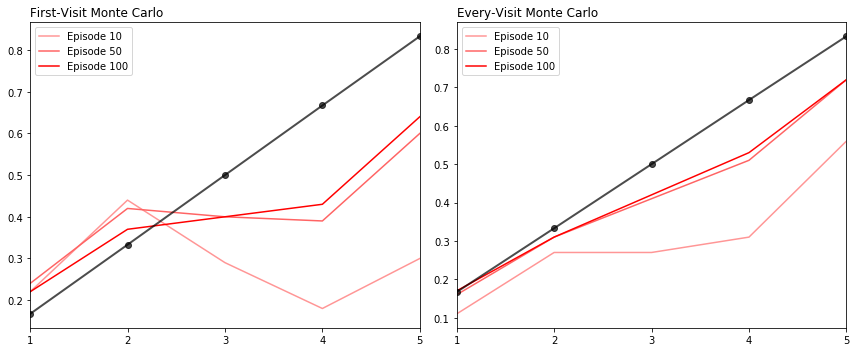

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colours = ('#ff9696','#ff6464','#ff0000')

_ = pd.DataFrame(first_values, columns=range(1, 6)).T.plot(color=colours, ax=ax[0])
_ = ax[0].set_xticks(range(1, 6))
_ = ax[0].set_xlim(0.9, 5.1)
_ = ax[0].set_title('First-Visit Monte Carlo', loc='left')
_ = ax[0].legend([f'Episode {cp + 1}' for cp in checkpoints])

_ = pd.DataFrame(every_values, columns=range(1, 6)).T.plot(color=colours, ax=ax[1])
_ = ax[1].set_xticks(range(1, 6))
_ = ax[1].set_xlim(0.9, 5.1)
_ = ax[1].set_title('Every-Visit Monte Carlo', loc='left')
_ = ax[1].legend([f'Episode {cp + 1}' for cp in checkpoints])

for a in ax:
    _ = true_values.plot(ax=a, color='k', linewidth=2, marker='o', alpha=0.7)
    
plt.tight_layout()

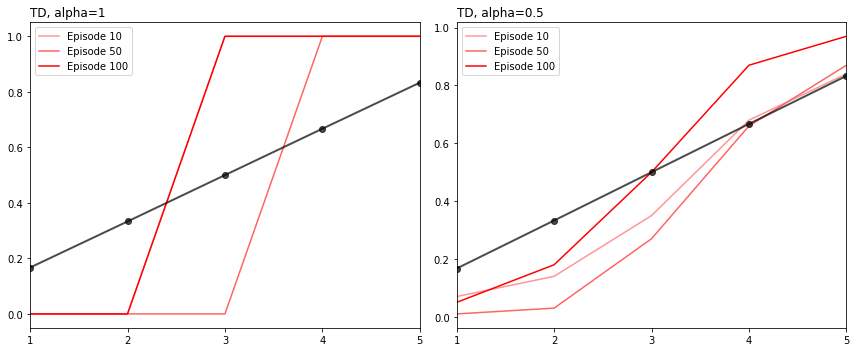

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colours = '#ff9696','#ff6464','#ff0000'

_ = pd.DataFrame(one_values, columns=range(1, 6)).T.plot(ax=ax[0], color=colours)
_ = ax[0].set_xticks(range(1, 6))
_ = ax[0].set_xlim(0.9, 5.1)
_ = ax[0].set_title('TD, alpha=1', loc='left')
_ = ax[0].legend([f'Episode {cp + 1}' for cp in checkpoints])

_ = pd.DataFrame(half_values, columns=range(1, 6)).T.plot(ax=ax[1], color=colours)
_ = ax[1].set_xticks(range(1, 6))
_ = ax[1].set_xlim(0.9, 5.1)
_ = ax[1].set_title('TD, alpha=0.5', loc='left')
_ = ax[1].legend([f'Episode {cp + 1}' for cp in checkpoints])

for a in ax:
    _ = true_values.plot(ax=a, color='k', linewidth=2, marker='o', alpha=0.7)
    
plt.tight_layout()